<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/burgers_equation_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burgers equation:
## Problem setup

We will solve a Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1]
$$

with the Dirichlet boundary conditions and initial conditions:

$$
u(-1, t) = u(1, t) = 0, \quad u(x, 0) = -\sin(\pi x).
$$

The reference solution is [Here](https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz)


In [97]:
import requests
import scipy.io
import torch
import io

In [98]:
# Step 1: GitHub raw URL to the .mat file
url = "https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat"

# Step 2: Download the file content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 3: Load the .mat file into memory
mat_data = scipy.io.loadmat(io.BytesIO(response.content))

# Step 4: Inspect the keys in the .mat file
print("Keys in the .mat file:", mat_data.keys())

# Step 5: Extract specific variables and convert to PyTorch tensors
usol = torch.tensor(mat_data['usol'], dtype=torch.float32)  # Solution variable
x = torch.tensor(mat_data['x'], dtype=torch.float32)        # Spatial grid
t = torch.tensor(mat_data['t'], dtype=torch.float32)        # Time grid

# Step 6: Print shapes of the loaded tensors
print(f"Shape of u(x, t): {usol.shape}")
print(f"Shape of x: {x.shape}")
print(f"Shape of t: {t.shape}")

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])
Shape of u(x, t): torch.Size([256, 100])
Shape of x: torch.Size([256, 1])
Shape of t: torch.Size([100, 1])


## Implementation

In [99]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [100]:
# Step 1: Define the Burgers' PDE components
def burgers_pde_residual(model, x, t, nu):
    """
    Compute the PDE residual for Burgers' equation:
    ∂u/∂t + u∂u/∂x - ν∂²u/∂x² = 0
    """
    x.requires_grad = True
    t.requires_grad = True
    u = model(torch.cat((x, t), dim=1))

    # Gradients w.r.t. x and t
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Second-order derivative w.r.t. x
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: ∂u/∂t + u∂u/∂x - ν∂²u/∂x²
    residual = u_t + u * u_x - nu * u_xx
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for Burgers' equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (x, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: u(x, t)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = burgers_pde_residual(model, x_interior, t_interior, nu)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss: u(-1, t) = 0 and u(1, t) = 0
    u_boundary_left = model(torch.cat((x_boundary[0], t_boundary), dim=1))
    u_boundary_right = model(torch.cat((x_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(u_boundary_left**2) + torch.mean(u_boundary_right**2)

    # Initial condition loss: u(x, 0) = -sin(πx)
    u_initial_pred = model(torch.cat((x_initial, t_initial), dim=1))
    ic_loss = torch.mean((u_initial_pred - u_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [101]:
# Step 5: Generate training data
# Domain: x ∈ [-1, 1], t ∈ [0, 1]
nu = 0.01 / np.pi  # Viscosity
#x = torch.linspace(-1, 1, 256).view(-1, 1)
#t = torch.linspace(0, 1, 100).view(-1, 1)

# Create mesh grid for interior points
x_grid, t_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
x_interior = x_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
x_boundary = [torch.full_like(t, -1), torch.full_like(t, 1)]
t_boundary = t

# Initial points
x_initial = x
t_initial = torch.zeros_like(x)
u_initial = -torch.sin(np.pi * x)

In [102]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, t_interior, x_boundary, t_boundary, x_initial, t_initial, u_initial, nu)

Adam Epoch 0, Loss: 0.5839716792106628
Adam Epoch 100, Loss: 0.3397012948989868
Adam Epoch 200, Loss: 0.1515403687953949
Adam Epoch 300, Loss: 0.1347951591014862
Adam Epoch 400, Loss: 0.12051659822463989
Adam Epoch 500, Loss: 0.11098343133926392
Adam Epoch 600, Loss: 0.10375134646892548
Adam Epoch 700, Loss: 0.09915199875831604
Adam Epoch 800, Loss: 0.09553471207618713
Adam Epoch 900, Loss: 0.0919438898563385
Starting LBFGS optimization...


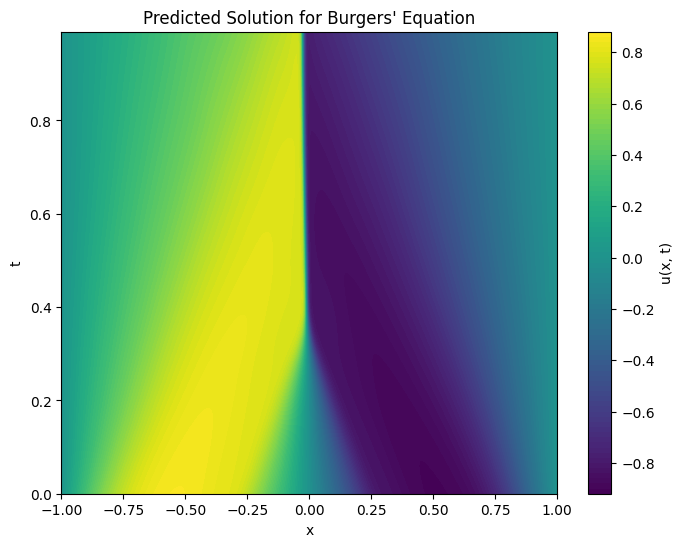

In [114]:
# Step 7: Visualize the results (optional)
# Create a grid for prediction
x_pred = x
t_pred = t
x_grid_pred, t_grid_pred = torch.meshgrid(x_pred.squeeze(), t_pred.squeeze(), indexing='ij')
x_flat = x_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
u_pred = model(torch.cat((x_flat, t_flat), dim=1)).detach().numpy()
u_pred = u_pred.reshape(256, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid_pred.numpy(), t_grid_pred.numpy(), u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution for Burgers\' Equation')
plt.show()

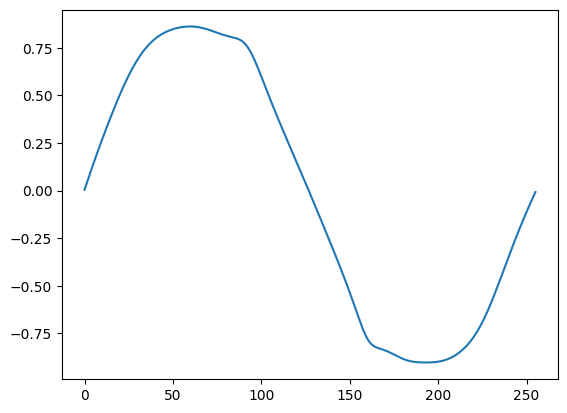

In [115]:
plt.plot(u_pred[:,0])

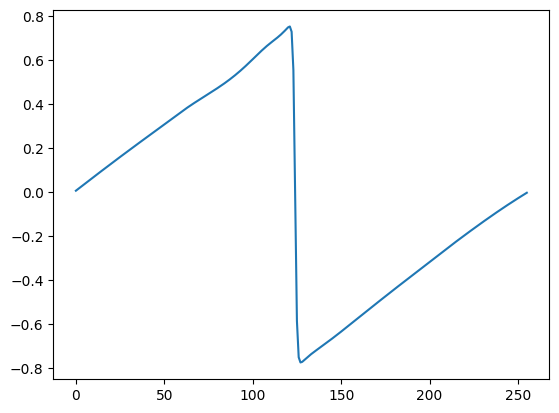

In [116]:
plt.plot(u_pred[:,-1])

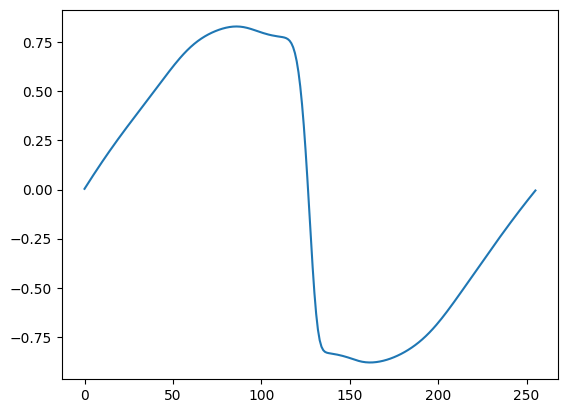

In [117]:
plt.plot(u_pred[:,30])

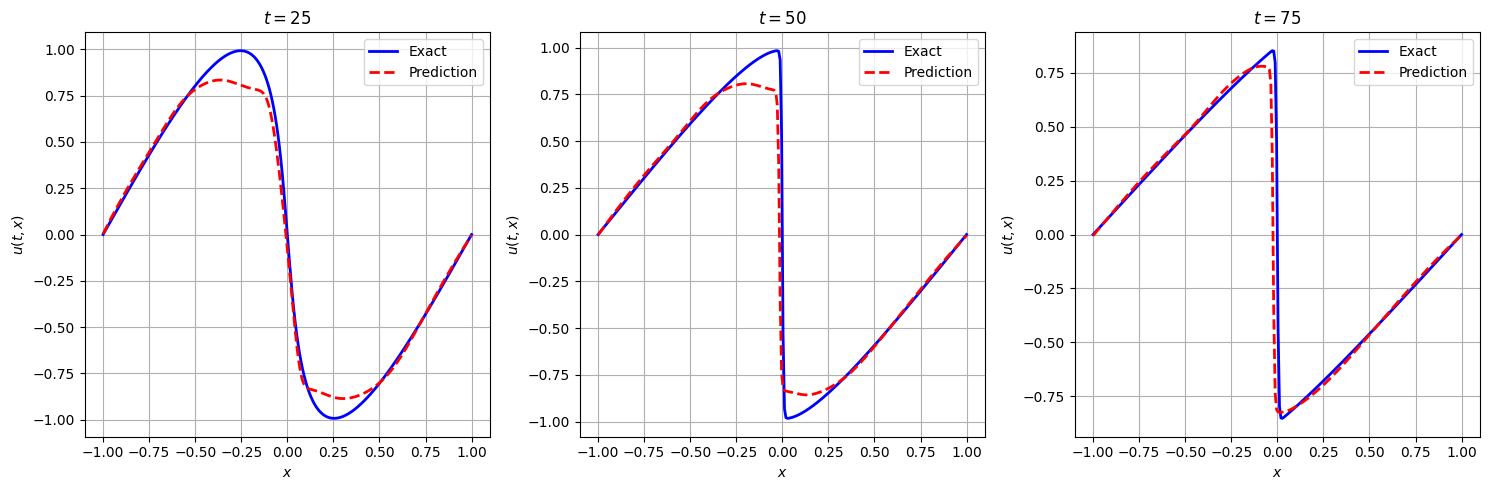

In [120]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 50, 75]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(x, t_slice)
    u_pred_slice = u_pred[:, t_slice]

    # Compute exact solution
    u_exact_slice = usol[:,t_slice]

    u_pred[:,30]


    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(x.numpy(), u_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(x.numpy(), u_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$u(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
